# Week 8, Day 1: Decision Trees & Random Forests for Trading

## Learning Objectives
- Understand decision tree mechanics for financial prediction
- Implement Random Forest for return prediction
- Analyze feature importance for trading signals
- Compare tree-based models with linear models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load data
data_path = '../datasets/raw_data/combined_adjusted_close.csv'
prices = pd.read_csv(data_path, index_col='Date', parse_dates=True)
print(f"Data shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")

Data shape: (1836, 63)
Date range: 2019-01-01 00:00:00 to 2026-01-19 00:00:00


## 1. Feature Engineering for ML

In [2]:
def create_ml_features(price_series, ticker):
    """
    Create machine learning features from price data.
    All features are lagged to avoid look-ahead bias.
    """
    df = pd.DataFrame(index=price_series.index)
    
    # Returns at different horizons (lagged)
    df['ret_1d'] = price_series.pct_change(1).shift(1)
    df['ret_5d'] = price_series.pct_change(5).shift(1)
    df['ret_10d'] = price_series.pct_change(10).shift(1)
    df['ret_20d'] = price_series.pct_change(20).shift(1)
    
    # Moving averages
    df['sma_5'] = price_series.rolling(5).mean().shift(1)
    df['sma_20'] = price_series.rolling(20).mean().shift(1)
    df['sma_50'] = price_series.rolling(50).mean().shift(1)
    
    # Price relative to MAs
    df['price_to_sma5'] = (price_series.shift(1) / df['sma_5']) - 1
    df['price_to_sma20'] = (price_series.shift(1) / df['sma_20']) - 1
    df['sma5_to_sma20'] = (df['sma_5'] / df['sma_20']) - 1
    
    # Volatility
    df['volatility_10d'] = price_series.pct_change().rolling(10).std().shift(1)
    df['volatility_20d'] = price_series.pct_change().rolling(20).std().shift(1)
    
    # RSI (14-day)
    delta = price_series.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi'] = (100 - 100 / (1 + rs)).shift(1)
    
    # Target: Next day return and direction
    df['target_return'] = price_series.pct_change(1).shift(-1)  # Next day return
    df['target_direction'] = (df['target_return'] > 0).astype(int)
    
    return df.dropna()

# Create features for SPY
spy_features = create_ml_features(prices['SPY'], 'SPY')
print(f"Features created: {spy_features.shape[0]} samples, {spy_features.shape[1]} columns")
print(f"\nFeature columns:")
print([col for col in spy_features.columns if col not in ['target_return', 'target_direction']])

Features created: 90 samples, 15 columns

Feature columns:
['ret_1d', 'ret_5d', 'ret_10d', 'ret_20d', 'sma_5', 'sma_20', 'sma_50', 'price_to_sma5', 'price_to_sma20', 'sma5_to_sma20', 'volatility_10d', 'volatility_20d', 'rsi']


## 2. Decision Tree for Direction Prediction

In [3]:
# Prepare data
feature_cols = [col for col in spy_features.columns if col not in ['target_return', 'target_direction']]
X = spy_features[feature_cols]
y = spy_features['target_direction']

# Time series split (no shuffle!)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training period: {X_train.index[0]} to {X_train.index[-1]} ({len(X_train)} samples)")
print(f"Testing period: {X_test.index[0]} to {X_test.index[-1]} ({len(X_test)} samples)")

Training period: 2019-11-12 00:00:00 to 2025-05-19 00:00:00 (72 samples)
Testing period: 2025-05-20 00:00:00 to 2025-11-27 00:00:00 (18 samples)


In [4]:
# Train decision trees with different depths
results = []
for depth in [2, 3, 5, 10, None]:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    
    results.append({
        'max_depth': str(depth),
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'n_leaves': tree.get_n_leaves()
    })

results_df = pd.DataFrame(results)
print("Decision Tree: Effect of Max Depth")
print("="*60)
print(results_df.to_string(index=False))
print("\n⚠️ Notice: Deep trees overfit (high train acc, lower test acc)")

Decision Tree: Effect of Max Depth
max_depth  train_accuracy  test_accuracy  n_leaves
        2        0.722222       0.611111         4
        3        0.819444       0.611111         6
        5        0.916667       0.555556        14
       10        1.000000       0.555556        20
     None        1.000000       0.555556        20

⚠️ Notice: Deep trees overfit (high train acc, lower test acc)


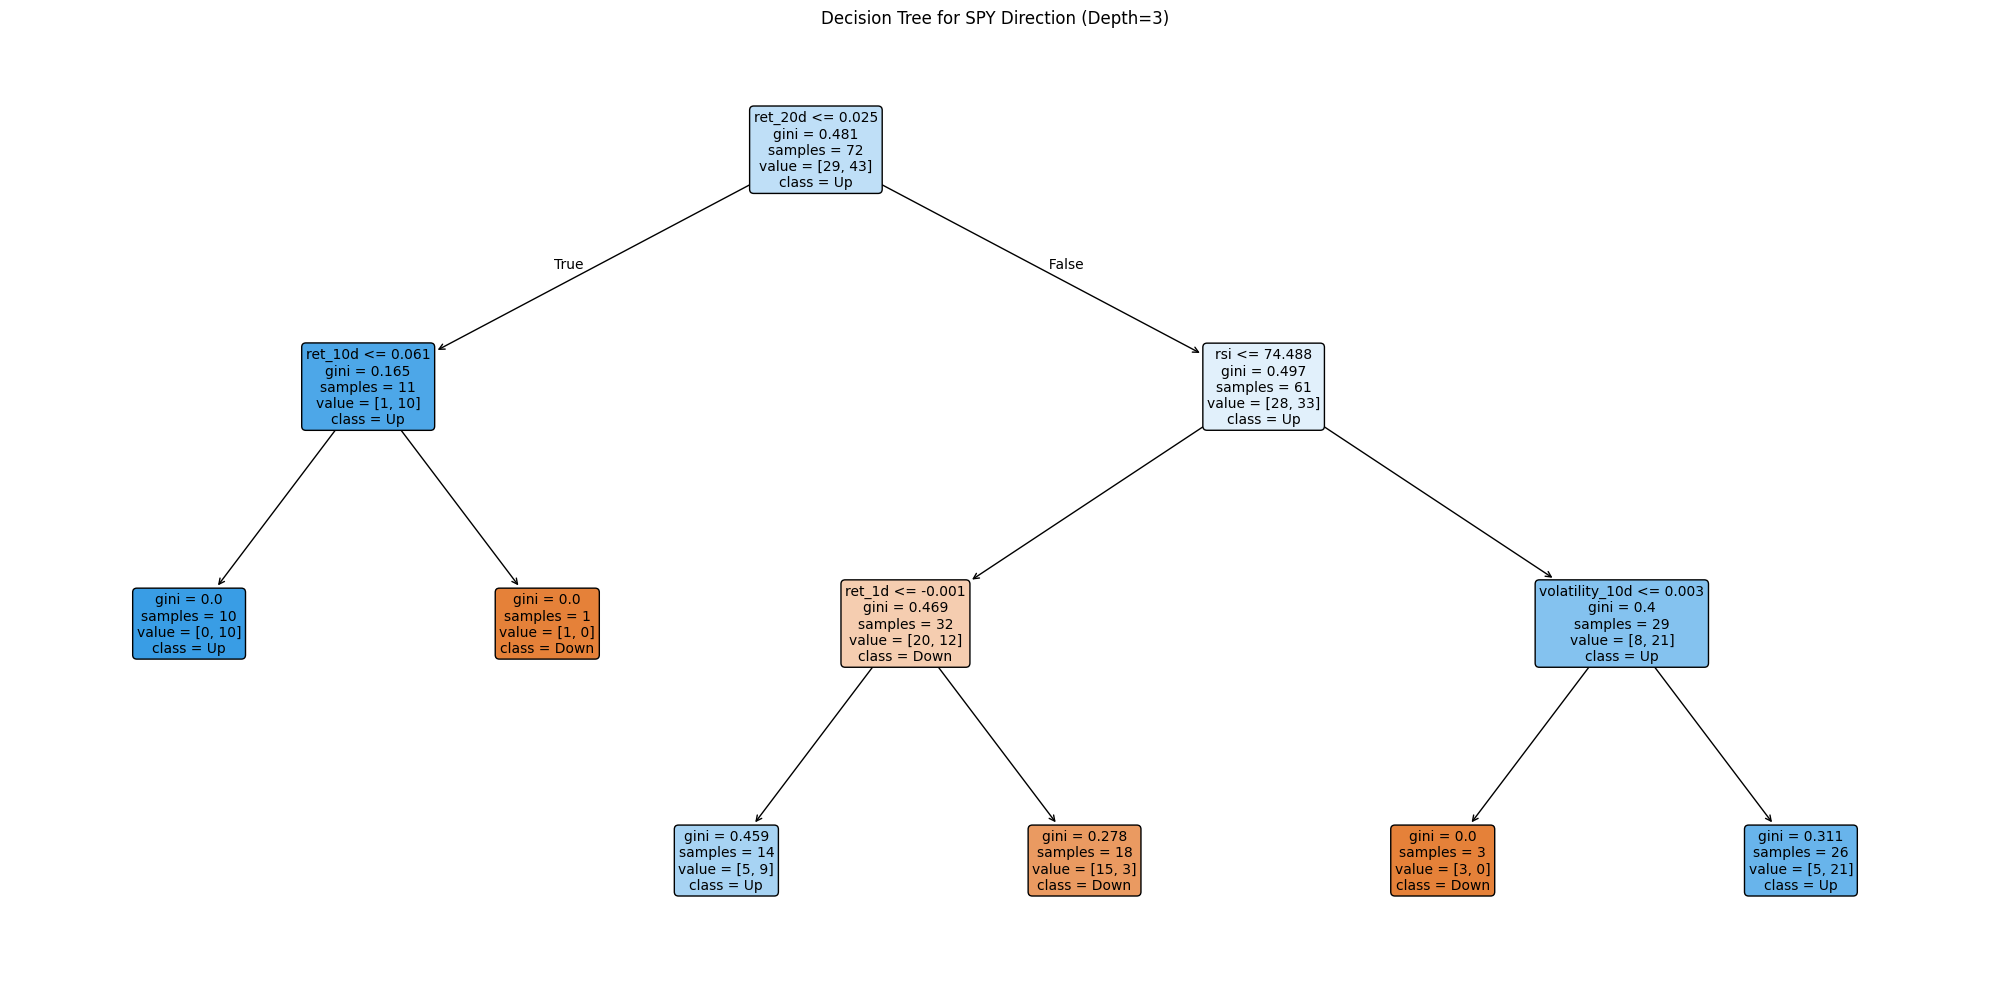

In [5]:
# Visualize a simple tree
simple_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
simple_tree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(simple_tree, feature_names=feature_cols, class_names=['Down', 'Up'],
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree for SPY Direction (Depth=3)')
plt.tight_layout()
plt.show()

## 3. Random Forest Implementation

In [6]:
# Random Forest with different configurations
rf_results = []

configs = [
    {'n_estimators': 50, 'max_depth': 3},
    {'n_estimators': 100, 'max_depth': 3},
    {'n_estimators': 100, 'max_depth': 5},
    {'n_estimators': 200, 'max_depth': 5},
    {'n_estimators': 100, 'max_depth': 10},
]

for config in configs:
    rf = RandomForestClassifier(
        n_estimators=config['n_estimators'],
        max_depth=config['max_depth'],
        max_features='sqrt',
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    rf_results.append({
        'n_estimators': config['n_estimators'],
        'max_depth': config['max_depth'],
        'train_acc': rf.score(X_train, y_train),
        'oob_acc': rf.oob_score_,
        'test_acc': rf.score(X_test, y_test)
    })

rf_df = pd.DataFrame(rf_results)
print("Random Forest: Configuration Comparison")
print("="*70)
print(rf_df.to_string(index=False))

Random Forest: Configuration Comparison
 n_estimators  max_depth  train_acc  oob_acc  test_acc
           50          3   0.888889 0.513889  0.500000
          100          3   0.888889 0.472222  0.611111
          100          5   1.000000 0.500000  0.500000
          200          5   1.000000 0.555556  0.500000
          100         10   1.000000 0.458333  0.444444


In [7]:
# Best Random Forest model
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=20,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest)")
print("="*50)
for _, row in importance_df.iterrows():
    bars = "█" * int(row['importance'] * 50)
    print(f"{row['feature']:20s}: {row['importance']:.3f} {bars}")


Feature Importance (Random Forest)
ret_1d              : 0.173 ████████
ret_20d             : 0.163 ████████
ret_5d              : 0.112 █████
price_to_sma5       : 0.112 █████
sma_50              : 0.102 █████
ret_10d             : 0.071 ███
sma_5               : 0.071 ███
price_to_sma20      : 0.071 ███
sma_20              : 0.051 ██
rsi                 : 0.031 █
sma5_to_sma20       : 0.020 █
volatility_20d      : 0.020 █
volatility_10d      : 0.000 


## 4. Probability Calibration and Trading Signals

In [8]:
# Get probability predictions
proba_train = best_rf.predict_proba(X_train)[:, 1]
proba_test = best_rf.predict_proba(X_test)[:, 1]

# Create trading signals based on confidence
def generate_signals(probabilities, threshold_high=0.55, threshold_low=0.45):
    """
    Generate trading signals:
    +1 = Long (high confidence up)
    -1 = Short (high confidence down)
     0 = No position (uncertain)
    """
    signals = np.zeros(len(probabilities))
    signals[probabilities > threshold_high] = 1
    signals[probabilities < threshold_low] = -1
    return signals

# Generate signals
signals_test = generate_signals(proba_test)

print("Trading Signals Distribution")
print("="*50)
print(f"Long signals:  {np.sum(signals_test == 1)} ({np.mean(signals_test == 1):.1%})")
print(f"Short signals: {np.sum(signals_test == -1)} ({np.mean(signals_test == -1):.1%})")
print(f"No position:   {np.sum(signals_test == 0)} ({np.mean(signals_test == 0):.1%})")

Trading Signals Distribution
Long signals:  18 (100.0%)
Short signals: 0 (0.0%)
No position:   0 (0.0%)


In [9]:
# Backtest signals
test_returns = spy_features.loc[X_test.index, 'target_return']
strategy_returns = signals_test * test_returns.values

# Performance metrics
cumulative_strategy = (1 + pd.Series(strategy_returns, index=X_test.index)).cumprod()
cumulative_buyhold = (1 + test_returns).cumprod()

print("\nStrategy Performance (Test Period)")
print("="*50)
print(f"Strategy Total Return: {cumulative_strategy.iloc[-1] - 1:.2%}")
print(f"Buy & Hold Return: {cumulative_buyhold.iloc[-1] - 1:.2%}")
print(f"Strategy Sharpe: {np.sqrt(252) * strategy_returns.mean() / strategy_returns.std():.2f}")
print(f"Buy & Hold Sharpe: {np.sqrt(252) * test_returns.mean() / test_returns.std():.2f}")


Strategy Performance (Test Period)
Strategy Total Return: -0.23%
Buy & Hold Return: -0.23%
Strategy Sharpe: -0.11
Buy & Hold Sharpe: -0.11


## 5. Random Forest for Return Prediction (Regression)

In [10]:
# Regression target
y_reg = spy_features['target_return']
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

# Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train, y_reg_train)

# Predictions
pred_train = rf_reg.predict(X_train)
pred_test = rf_reg.predict(X_test)

print("Random Forest Regression Results")
print("="*50)
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_reg_train, pred_train)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_reg_test, pred_test)):.4f}")
print(f"Train R²: {rf_reg.score(X_train, y_reg_train):.4f}")
print(f"Test R²: {rf_reg.score(X_test, y_reg_test):.4f}")

# Direction accuracy from regression
direction_acc = np.mean((pred_test > 0) == (y_reg_test > 0))
print(f"\nDirection accuracy (from regression): {direction_acc:.2%}")

Random Forest Regression Results
Train RMSE: 0.0068
Test RMSE: 0.0105
Train R²: 0.0531
Test R²: -0.0314

Direction accuracy (from regression): 50.00%


## 6. Practice Exercises

1. **Multiple Stocks**: Train separate RF models for different stocks. Compare feature importance across assets.

2. **Feature Selection**: Use only top 5 features by importance. Does performance improve?

3. **Threshold Optimization**: Find optimal probability thresholds for trading signals.

4. **Cross-Asset Features**: Add SPY features when predicting individual stocks.

In [11]:
# Exercise starter: Train RF for multiple stocks
stocks_to_test = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
stock_results = []

for ticker in stocks_to_test:
    if ticker not in prices.columns:
        continue
    
    # Create features
    features = create_ml_features(prices[ticker], ticker)
    
    # Prepare data
    X_stock = features[feature_cols]
    y_stock = features['target_direction']
    
    # Split
    split = int(len(X_stock) * 0.8)
    X_tr, X_te = X_stock.iloc[:split], X_stock.iloc[split:]
    y_tr, y_te = y_stock.iloc[:split], y_stock.iloc[split:]
    
    # Train RF
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    
    stock_results.append({
        'ticker': ticker,
        'train_acc': rf.score(X_tr, y_tr),
        'test_acc': rf.score(X_te, y_te),
        'top_feature': feature_cols[np.argmax(rf.feature_importances_)]
    })

print("\nRandom Forest Results Across Stocks")
print("="*60)
print(pd.DataFrame(stock_results).to_string(index=False))


Random Forest Results Across Stocks
ticker  train_acc  test_acc    top_feature
  AAPL   1.000000  0.611111 price_to_sma20
  MSFT   1.000000  0.444444         ret_1d
 GOOGL   1.000000  0.611111         ret_1d
  AMZN   0.986111  0.611111         ret_1d


## Summary

Today we learned:
- Decision trees split data recursively to minimize impurity
- Random Forest reduces overfitting through bagging and feature randomization
- Feature importance helps identify key trading signals
- Probability outputs can generate trading signals with confidence thresholds
- Always use chronological splits for financial data (no shuffling!)